# Building a Spam Filter with Naive Bayes from scratch

In this project, we're going to build a spam filter for SMS messages using the multinomial Naive Bayes algorithm from scratch in order to learn how the algorithms works beneath the surface. Our goal is to write a program that successfully classifies new messages with an accuracy greater than 80% — so we expect that more than 80% of the new messages will be classified correctly as spam or ham (non-spam).

## Exploring the Dataset

We'll start by reading in the dataset.

In [1]:
# import libraries
import pandas as pd
import numpy as np

sms_spam = pd.read_csv('SMSSpamCollection', sep='\t', header=None, names=['Label', 'SMS'])

print(sms_spam.shape)
sms_spam.head()

(5572, 2)


,Label,SMS
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


Let's get some information about our dataset.

In [2]:
sms_spam.info() # get some information on our dataset

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Label   5572 non-null   object
 1   SMS     5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


We don't have any missing values. Let's check if we have duplicates and remove them.

In [3]:
# check for duplicates
sms_spam.duplicated().sum()

403

In [4]:
# remove duplicate
sms_spam = sms_spam.drop_duplicates(keep='first')
print(sms_spam.shape)
sms_spam.head()

(5169, 2)


,Label,SMS
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


Let's find out what percentage of the messages are spam and what percentage are ham ("ham" means non-spam)

In [5]:
sms_spam['Label'].value_counts(normalize=True)

ham     0.87367
spam    0.12633
Name: Label, dtype: float64

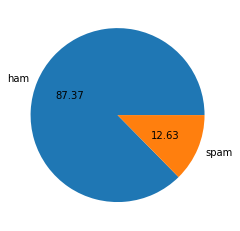

In [6]:
# Let's visualise the Label column
import matplotlib.pyplot as plt
plt.pie(sms_spam['Label'].value_counts(), labels=['ham', 'spam'], autopct="%0.2f")
plt.show()

We see that about 87% of the messages are ham, and the remaining 13% are spam. This sample looks representative, since in practice most messages that people receive are ham. Also, this means that the dataset is imbalanced, were one classification is more represented than the other one.

## Training and Test Set

We're now going to split our dataset into a training and a test set, where the training set accounts for 80% of the data, and the test set for the remaining 20%.

In [7]:
# Randomize the dataset
data_randomized = sms_spam.sample(frac=1, random_state=1)

# Calculate index for split
training_test_index = round(len(data_randomized) * 0.8)

# Training/Test split
training_set = data_randomized[:training_test_index].reset_index(drop=True)
test_set = data_randomized[training_test_index:].reset_index(drop=True)

print(training_set.shape)
print(test_set.shape)

(4135, 2)
(1034, 2)


We'll now analyze the percentage of spam and ham messages in the training and test sets. We expect the percentages to be close to what we have in the full dataset, where about 87% of the messages are ham, and the remaining 13% are spam.

In [8]:
training_set['Label'].value_counts(normalize=True)

ham     0.879565
spam    0.120435
Name: Label, dtype: float64

In [9]:
test_set['Label'].value_counts(normalize=True)

ham     0.850097
spam    0.149903
Name: Label, dtype: float64

The results look good, as both classes are well represented similarly from the original dataset. That's awesome! Now we're moving to cleaning the dataset.

## Data Cleaning

To make all calculations easier of the probabilities required by the algorithm, we'll first need to perform a bit of data cleaning to bring the data in a format that will allow us to extract easily all the information we need.


Essentialy, we want to bring data to this format:

![img](cpgp_dataset_3.png)


### Letter Case and Punctuation

We'll begin with removing all the punctuation and bringing every letter to lower case.

In [10]:
# Before cleaning
training_set.head()

,Label,SMS
0,ham,Ok. But i finish at 6.
1,spam,87077: Kick off a new season with 2wks FREE go...
2,ham,Ron say fri leh. N he said ding tai feng cant ...
3,spam,Do you want a new Video phone? 600 anytime any...
4,ham,"I prefer my free days... Tues, wed, fri oso ca..."


In [11]:
# After cleaning
training_set['SMS'] = training_set['SMS'].str.replace('\W', ' ', regex=True)
training_set['SMS'] = training_set['SMS'].str.lower()
training_set.head()

,Label,SMS
0,ham,ok but i finish at 6
1,spam,87077 kick off a new season with 2wks free go...
2,ham,ron say fri leh n he said ding tai feng cant ...
3,spam,do you want a new video phone 600 anytime any...
4,ham,i prefer my free days tues wed fri oso ca...


## Creating the Vocabulary

Let's now move to creating the vocabulary, which in this context means a list with all the unique words in our training set.

In [12]:
training_set['SMS'] = training_set['SMS'].str.split() # transform the SMS column into a list of strings

vocabulary = []
for sms in training_set['SMS']:
    for word in sms:
        vocabulary.append(word)
        
vocabulary = list(set(vocabulary))
len(vocabulary)

7612

It looks like there are 7,612 unique words in all the messages of our training set.

## The Final Training Set

We're now going to use the vocabulary we just created to make the data transformation we want.

In [13]:
# Initialize a dictionary in which each word in vocabulary is set to 0 for each SMS
word_counts_per_sms = {unique_word: [0] * len(training_set['SMS']) for unique_word in vocabulary} # creating a dictionary for our dataframe

for index, sms in enumerate(training_set['SMS']):
    for word in sms:
        word_counts_per_sms[word][index] += 1

In [14]:
word_counts = pd.DataFrame(word_counts_per_sms)
word_counts.head()

,areyouunique,ths,plenty,attending,buff,2years,reltnship,aight,petrol,strips,...,key,december,planning,sha,spoon,whats,2p,easier,09111030116,billy
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Awesome, we're now going to merge our vocabulary dictionary with our training_set data to form the dataframe we seek.

In [15]:
training_set_clean = pd.concat([training_set, word_counts], axis=1)
training_set_clean.head()

,Label,SMS,areyouunique,ths,plenty,attending,buff,2years,reltnship,aight,...,key,december,planning,sha,spoon,whats,2p,easier,09111030116,billy
0,ham,"[ok, but, i, finish, at, 6]",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,spam,"[87077, kick, off, a, new, season, with, 2wks,...",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,ham,"[ron, say, fri, leh, n, he, said, ding, tai, f...",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,spam,"[do, you, want, a, new, video, phone, 600, any...",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,ham,"[i, prefer, my, free, days, tues, wed, fri, os...",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Calculating Constants First

We're now done with cleaning the training set, and we can begin creating the spam filter. The Naive Bayes algorithm will need to answer these two probability questions to be able to classify new messages:

\begin{equation*}
P(Spam | w_1,w_2, ..., w_n) \propto P(Spam) \cdot \prod_{i=1}^{n}P(w_i|Spam)
\end{equation*}

\begin{equation*}
P(Ham | w_1,w_2, ..., w_n) \propto P(Ham) \cdot \prod_{i=1}^{n}P(w_i|Ham)
\end{equation*}

Also, to calculate P(w<sub>i</sub>|Spam) and P(w<sub>i</sub>|Ham) inside the formulas above, we'll need to use these equations:

\begin{equation*}
P(w_i|Spam) = \frac{N_{w_i|Spam} + \alpha}{N_{Spam} + \alpha \cdot N_{Vocabulary}}
\end{equation*}

\begin{equation*}
P(w_i|Ham) = \frac{N_{w_i|Ham} + \alpha}{N_{Ham} + \alpha \cdot N_{Vocabulary}}
\end{equation*}

The terms in the two equations above mean:

- $N_{w_i|Spam} = $ the number of times the word $w_i$ occurs in spam messages
- $N_{w_i|ham} = $ the number of times the word $w_i$ occurs in ham messages
- $N_{Spam} = $ total number of words in spam messages
- $N_{ham} = $ total number of words in ham messages
- $N_{Vocabulary} = $ total number of words in the vocabulary
- $\alpha = 1$ ($\alpha$ is the Laplace smoothing operator)



Some of the terms in the four equations above will have the same value for every new message. We can calculate the value of these terms once and avoid doing the computations again when a new messages comes in. Below, we'll use our training set to calculate:

- P(Spam) and P(Ham)
- N<sub>Spam</sub>, N<sub>Ham</sub>, N<sub>Vocabulary</sub>
- and set $\alpha = 1$.

In [16]:
# Isolating spam and ham messages first
spam_messages = training_set_clean[training_set_clean['Label'] == 'spam']
ham_messages = training_set_clean[training_set_clean['Label'] == 'ham']

# P(Spam) and P(Ham)
p_spam = len(spam_messages) / len(training_set_clean)
p_ham = len(ham_messages) / len(training_set_clean)

# N_Spam
n_words_per_spam_message = spam_messages['SMS'].apply(len)
n_spam = n_words_per_spam_message.sum()

# N_Ham
n_words_per_ham_message = ham_messages['SMS'].apply(len)
n_ham = n_words_per_ham_message.sum()

# N_Vocabulary
n_vocabulary = len(vocabulary)

# Laplace smoothing
alpha = 1

## Calculating Parameters

Now that we have the constant terms calculated above, we can move on with calculating the parameters $P(w_i|Spam)$ and $P(w_i|Ham)$. Each parameter will thus be a conditional probability value associated with each word in the vocabulary.

The parameters are calculated using the formulas:

\begin{equation*}
P(w_i|Spam) = \frac{N_{w_i|Spam} + \alpha}{N_{Spam} + \alpha \cdot N_{Vocabulary}}
\end{equation*}

\begin{equation*}
P(w_i|Ham) = \frac{N_{w_i|Ham} + \alpha}{N_{Ham} + \alpha \cdot N_{Vocabulary}}
\end{equation*}

In [17]:
# Initiate parameters
parameters_spam = {unique_word:0 for unique_word in vocabulary}
parameters_ham = {unique_word:0 for unique_word in vocabulary}

# Calculate parameters
for word in vocabulary:
    n_word_given_spam = spam_messages[word].sum()   # spam_messages already defined in a cell above
    p_word_given_spam = (n_word_given_spam + alpha) / (n_spam + alpha*n_vocabulary)
    parameters_spam[word] = p_word_given_spam
    
    n_word_given_ham = ham_messages[word].sum()   # ham_messages already defined in a cell above
    p_word_given_ham = (n_word_given_ham + alpha) / (n_ham + alpha*n_vocabulary)
    parameters_ham[word] = p_word_given_ham

## Classifying A New Message

Now that we have all our parameters calculated, we can start creating the spam filter. The spam filter can be understood as a function that:

- Takes in as input a new message (w<sub>1</sub>, w<sub>2</sub>, ..., w<sub>n</sub>).
- Calculates P(Spam|w<sub>1</sub>, w<sub>2</sub>, ..., w<sub>n</sub>) and P(Ham|w<sub>1</sub>, w<sub>2</sub>, ..., w<sub>n</sub>).
- Compares the values of P(Spam|w<sub>1</sub>, w<sub>2</sub>, ..., w<sub>n</sub>) and P(Ham|w<sub>1</sub>, w<sub>2</sub>, ..., w<sub>n</sub>), and:
    - If P(Ham|w<sub>1</sub>, w<sub>2</sub>, ..., w<sub>n</sub>) > P(Spam|w<sub>1</sub>, w<sub>2</sub>, ..., w<sub>n</sub>), then the message is classified as ham.
    - If P(Ham|w<sub>1</sub>, w<sub>2</sub>, ..., w<sub>n</sub>) < P(Spam|w<sub>1</sub>, w<sub>2</sub>, ..., w<sub>n</sub>), then the message is classified as spam.
    -  If P(Ham|w<sub>1</sub>, w<sub>2</sub>, ..., w<sub>n</sub>) = P(Spam|w<sub>1</sub>, w<sub>2</sub>, ..., w<sub>n</sub>), then the algorithm may request human help.

In [18]:
import re

def classify(message):
    '''
    message: a string
    '''
    
    message = re.sub('\W', ' ', message)
    message = message.lower().split()
    
    p_spam_given_message = p_spam
    p_ham_given_message = p_ham

    for word in message:
        if word in parameters_spam:
            p_spam_given_message *= parameters_spam[word]
            
        if word in parameters_ham:
            p_ham_given_message *= parameters_ham[word]
            
    print('P(Spam|message):', p_spam_given_message)
    print('P(Ham|message):', p_ham_given_message)
    
    if p_ham_given_message > p_spam_given_message:
        print('Label: Ham')
    elif p_ham_given_message < p_spam_given_message:
        print('Label: Spam')
    else:
        print('Equal proabilities, have a human classify this!')

Let's test the classify function.

In [19]:
classify('WINNER!! This is the secret code to unlock the money: C3421.')

P(Spam|message): 8.127042930442235e-26
P(Ham|message): 1.0997819762771794e-27
Label: Spam


In [20]:
classify("Sounds good, Tom, then see u there")

P(Spam|message): 3.280733215371128e-25
P(Ham|message): 3.7255583099559524e-21
Label: Ham


## Measuring the Spam Filter's Accuracy

The two results above look promising, but let's see how well the filter does on our test set, which has 1,114 messages.

We'll start by writing a function that returns classification labels instead of printing them.

In [21]:
def classify_test_set(message):    
    '''
    message: a string
    '''
    
    message = re.sub('\W', ' ', message)
    message = message.lower().split()
    
    p_spam_given_message = p_spam
    p_ham_given_message = p_ham

    for word in message:
        if word in parameters_spam:
            p_spam_given_message *= parameters_spam[word]
            
        if word in parameters_ham:
            p_ham_given_message *= parameters_ham[word]
    
    if p_ham_given_message > p_spam_given_message:
        return 'ham'
    elif p_spam_given_message > p_ham_given_message:
        return 'spam'
    else:
        return 'needs human classification'

Now that we have a function that returns labels instead of printing them, we can use it to create a new column in our test set.

In [22]:
test_set['predicted'] = test_set['SMS'].apply(classify_test_set)
test_set.head()

,Label,SMS,predicted
0,ham,"Nothing, i got msg frm tht unknown no..",ham
1,ham,Jason says it's cool if we pick some up from h...,ham
2,ham,Call me when u're done...,ham
3,ham,Well there's not a lot of things happening in ...,ham
4,ham,I was about to do it when i texted. I finished...,ham


Now, we'll write a function to measure the accuracy of our spam filter to find out how well our spam filter does.

In [23]:
correct = 0
total = test_set.shape[0]

result = (test_set['Label'] == test_set['predicted'])
correct = result.sum()
    
# for row in test_set.iterrows():
#     row = row[1]
#     if row['Label'] == row['predicted']:
#         correct += 1
        
print('Correct:', correct)
print('Incorrect:', total - correct)
print('Accuracy:', correct/total)

Correct: 1018
Incorrect: 16
Accuracy: 0.9845261121856866


The accuracy is close to 98.45%, which is really good. Our spam filter looked at 1,114 messages that it hasn't seen in training, and classified 1,018 correctly.

Let's look at the 16 messages the spam filter got wrong.

In [24]:
wrong_classify_sms = test_set[test_set['Label'] != test_set['predicted']]
wrong_classify_sms

,Label,SMS,predicted
22,ham,26th OF JULY,spam
142,spam,In The Simpsons Movie released in July 2007 na...,ham
148,spam,Hello darling how are you today? I would love ...,ham
282,ham,Mathews or tait or edwards or anderson,spam
315,spam,thesmszone.com lets you send free anonymous an...,ham
407,spam,Hi I'm sue. I am 20 years old and work as a la...,ham
649,spam,Hi its LUCY Hubby at meetins all day Fri & I w...,ham
685,spam,"Hi babe its Chloe, how r u? I was smashed on s...",ham
732,ham,Finally the match heading towards draw as your...,spam
744,ham,Waiting for your call.,spam


We observe short messages and other messages are mixed in with characters that weren't cleaned properly. Why were those messages wrongly classified? We may ask. A possible solution is that some words occur only in one category (say one word in spam, and another in ham) and not the other. Another reason could be that the spammers got clever and figured out how to beat the algorithm.

# Conclusion

In this project, we managed to build a spam filter for SMS messages using the multinomial Naive Bayes algorithm. The filter had an accuracy of 98.45% on the test set we used, which is a pretty good result. Our initial goal was an accuracy of over 80%, and we managed to do way better than that. We analysed the 16 messages that the algorithm classified them incorrectly and came to a conclusion that the situation out of our hands. As with some spam message the sender was clever and got around the algorithm. Other messages is all about improving the algorithm.

Next step, we will build the SMS spam filter classifier using the scikit-learn library as it's what we would use in real-life in order to be more productive. We'll then compare the results with the one here. See you there.